In [ ]:
import cv2, numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

image_path = Path("dji_0016-1536x864.jpg")
overlap = 0.60
USE_MANUAL_ANGLES = True
angle_left_deg  = 17.3
angle_right_deg = 22.7
maxNFeatures = 4000

max_features = 6000
match_ratio = 0.72
ratio = 0.65

ransac_reproj_thresh = 3.0

assert image_path.exists(), f"File not found: {image_path}"

def imshow(img, title=None, size=(6,4)):
    plt.figure(figsize=size); plt.imshow(img); plt.axis("off")
    if title: plt.title(title)
    plt.show()

Input: (864, 1536, 3)


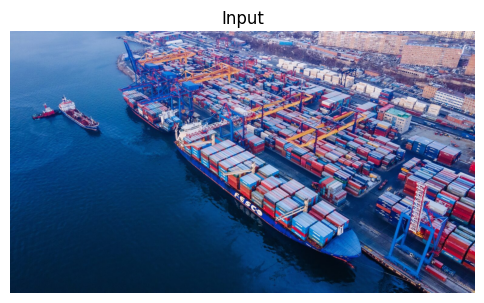

In [13]:
bgr = cv2.imread(str(image_path), cv2.IMREAD_COLOR)
img = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
H, W = img.shape[:2]
print("Input:", img.shape)
imshow(img, "Input")

left:(864, 921, 3), mid:(864, 921, 3), right:(864, 921, 3)


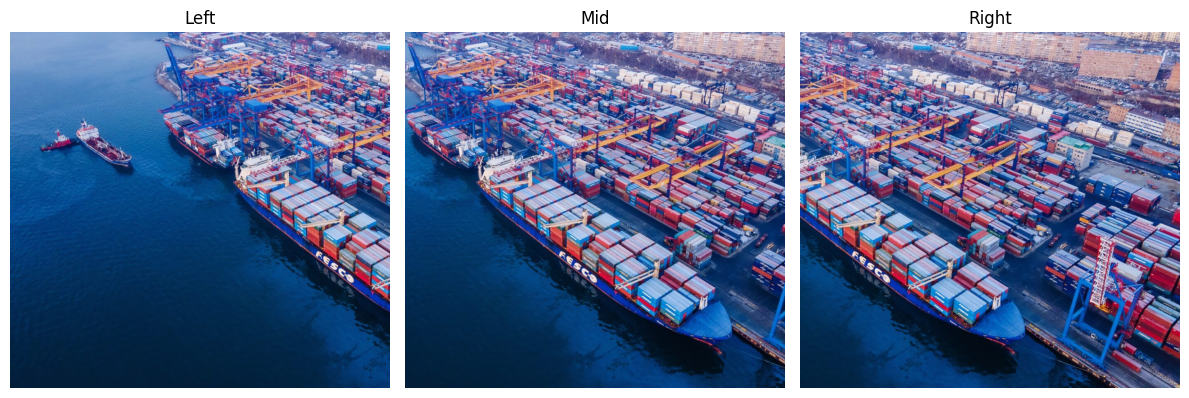

In [14]:
crop_w = int(0.60 * W)
step = int(crop_w * (1 - overlap))
x0 = 0
x1 = min(W - crop_w, step)
x2 = min(W - crop_w, 2 * step)

crop_left  = img[:, x0:x0+crop_w].copy()
crop_mid   = img[:, x1:x1+crop_w].copy()
crop_right = img[:, x2:x2+crop_w].copy()

print(f"left:{crop_left.shape}, mid:{crop_mid.shape}, right:{crop_right.shape}")
plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(crop_left);  plt.axis("off"); plt.title("Left")
plt.subplot(1,3,2); plt.imshow(crop_mid);   plt.axis("off"); plt.title("Mid")
plt.subplot(1,3,3); plt.imshow(crop_right); plt.axis("off"); plt.title("Right")
plt.tight_layout(); plt.show()

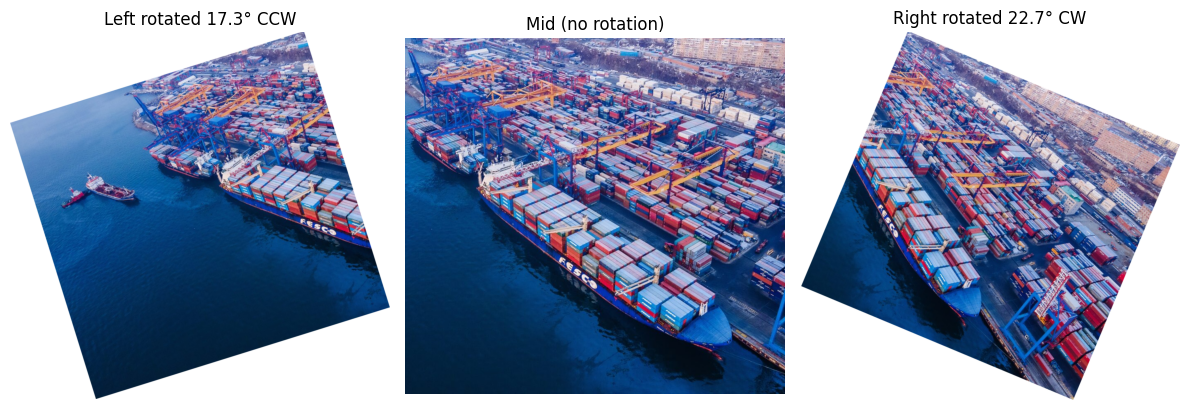

In [15]:
def rotate_expand(img_rgb, signed_angle_ccw, zoom=1.0, pad=0.0):
    h, w = img_rgb.shape[:2]
    c = (w/2.0, h/2.0)

    M = cv2.getRotationMatrix2D(c, signed_angle_ccw, zoom)

    cos_eff, sin_eff = abs(M[0,0]), abs(M[0,1])
    nW = int(np.ceil(w*cos_eff + h*sin_eff))
    nH = int(np.ceil(w*sin_eff + h*cos_eff))

    padW = int(np.ceil(nW * pad))
    padH = int(np.ceil(nH * pad))
    Nw = nW + 2*padW
    Nh = nH + 2*padH

    M[0,2] += Nw/2.0 - c[0]
    M[1,2] += Nh/2.0 - c[1]

    out = cv2.warpAffine(
        img_rgb, M, (Nw, Nh),
        flags=cv2.INTER_LINEAR,
        borderMode=cv2.BORDER_CONSTANT, borderValue=(255,255,255)
    )
    return out, M

ZOOM = 1.0
PAD = 0.0

if USE_MANUAL_ANGLES:
    angL_ccw = float(angle_left_deg)
    angR_cw = float(angle_right_deg)
    left_rot, ML = rotate_expand(crop_left, angL_ccw, zoom=ZOOM, pad=PAD)
    right_rot, MR = rotate_expand(crop_right, -angR_cw, zoom=ZOOM, pad=PAD)
else:
    left_rot = crop_left.copy()
    right_rot = crop_right.copy()

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(left_rot)
plt.axis("off")
plt.title(f"Left rotated {angle_left_deg}° CCW")

plt.subplot(1,3,2)
plt.imshow(crop_mid)
plt.axis("off")
plt.title("Mid (no rotation)")

plt.subplot(1,3,3)
plt.imshow(right_rot)
plt.axis("off")
plt.title(f"Right rotated {angle_right_deg}° CW")

plt.tight_layout()
plt.show()

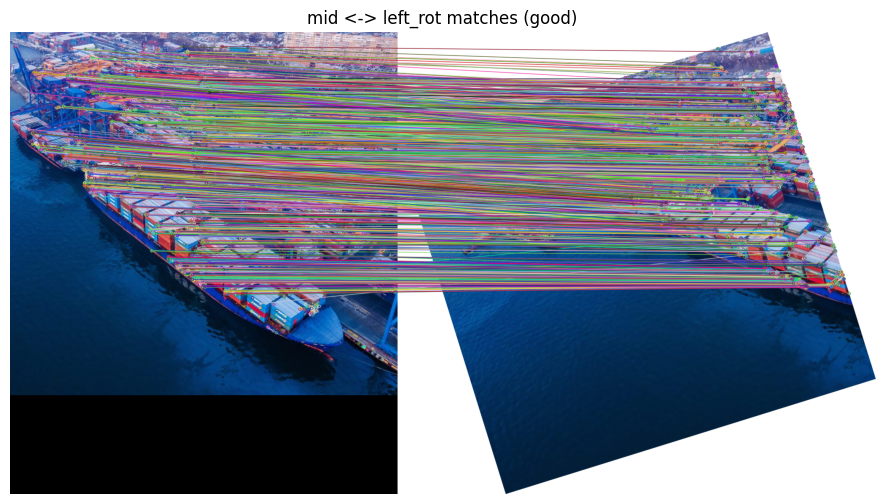

LEFT Homography matrix H_L:
[[ 9.59750962e-01 -3.00099977e-01 -2.88957227e+02]
 [ 2.98869010e-01  9.56793980e-01 -2.62683349e+02]
 [ 5.22967021e-06 -3.24572067e-06  1.00000000e+00]]
Number of good matches: 1456


In [ ]:
img1Gray_L = cv2.cvtColor(crop_mid,  cv2.COLOR_RGB2GRAY)   # dst
img2Gray_L = cv2.cvtColor(left_rot,  cv2.COLOR_RGB2GRAY)   # src

orb_L = cv2.ORB_create(maxNFeatures)
kps1_L, d1_L = orb_L.detectAndCompute(img1Gray_L, None)
kps2_L, d2_L = orb_L.detectAndCompute(img2Gray_L, None)
if d1_L is None or d2_L is None:
    raise RuntimeError("пустые дескрипторы (left)")

bf_L = cv2.BFMatcher(cv2.NORM_HAMMING)
m12_L = bf_L.knnMatch(d1_L, d2_L, k=2)

good_L = []
for m, n in m12_L:
    if m.distance < ratio * n.distance:
        good_L.append(m)

pts1_L = np.float32([kps1_L[m.queryIdx].pt for m in good_L]).reshape(-1, 2)  # dst
pts2_L = np.float32([kps2_L[m.trainIdx].pt for m in good_L]).reshape(-1, 2)  # src

imMatches_L = cv2.drawMatches(crop_mid, kps1_L, left_rot, kps2_L, good_L, None)
plt.figure(figsize=(14, 6))
plt.imshow(imMatches_L)
plt.axis("off")
plt.title("mid <-> left_rot matches (good)")
plt.show()

H_L, mask_L = cv2.findHomography(pts2_L, pts1_L, cv2.RANSAC, 5.0)
print("LEFT Homography matrix H_L:")
print(H_L)
print(f"Number of good matches: {len(good_L)}")

Canvas size: 1542 x 1389
Offsets: x_min=-621, y_min=-263


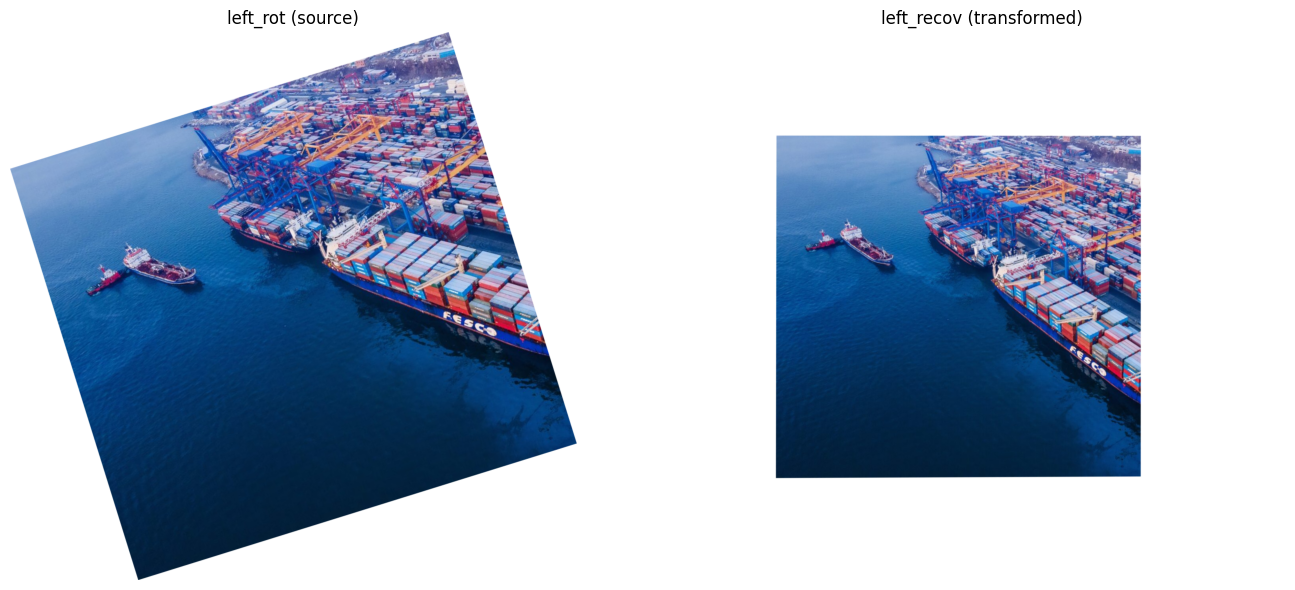

In [ ]:
h_mid, w_mid = crop_mid.shape[:2]
h_left, w_left = left_rot.shape[:2]

# Углы левой картинки
corners_left = np.float32([
    [0, 0],
    [w_left, 0],
    [w_left, h_left],
    [0, h_left]
]).reshape(-1, 1, 2)

# Трансформируем углы через гомографию
corners_transformed = cv2.perspectiveTransform(corners_left, H_L)

# Находим границы трансформированной левой картинки
x_min = int(np.floor(corners_transformed[:, 0, 0].min()))
x_max = int(np.ceil(corners_transformed[:, 0, 0].max()))
y_min = int(np.floor(corners_transformed[:, 0, 1].min()))
y_max = int(np.ceil(corners_transformed[:, 0, 1].max()))

x_min = min(x_min, 0)
x_max = max(x_max, w_mid)
y_min = min(y_min, 0)
y_max = max(y_max, h_mid)

canvas_width = x_max - x_min
canvas_height = y_max - y_min

print(f"Canvas size: {canvas_width} x {canvas_height}")
print(f"Offsets: x_min={x_min}, y_min={y_min}")

# Матрица сдвига для компенсации отрицательных координат
translation_matrix = np.array([
    [1, 0, -x_min],
    [0, 1, -y_min],
    [0, 0, 1]
], dtype=np.float32)

# сначала H_L, потом сдвиг
H_L_shifted = translation_matrix @ H_L

left_recov = cv2.warpPerspective(
    left_rot,
    H_L_shifted,
    (canvas_width, canvas_height),
    flags=cv2.INTER_LINEAR,
    borderMode=cv2.BORDER_CONSTANT,
    borderValue=(255, 255, 255)
)

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.imshow(left_rot)
plt.axis("off")
plt.title("left_rot (source)")

plt.subplot(1, 2, 2)
plt.imshow(left_recov)
plt.axis("off")
plt.title("left_recov (transformed)")
plt.tight_layout()
plt.show()

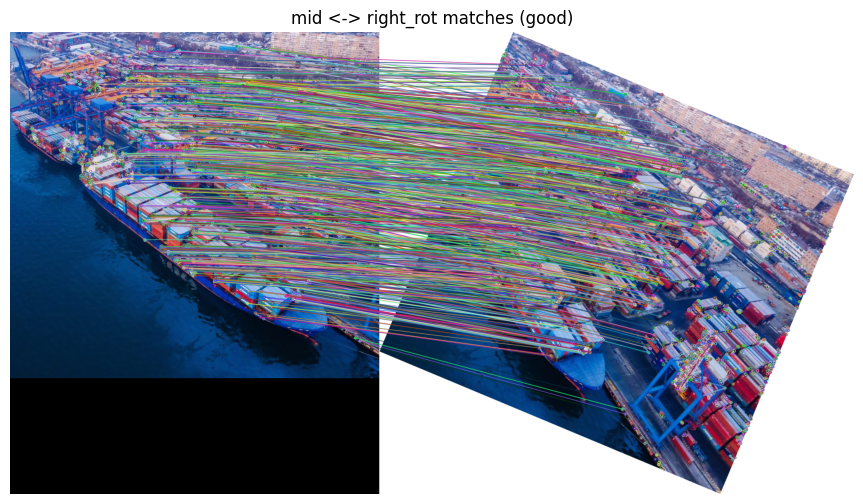

RIGHT Homography matrix H_R:
[[ 9.21321817e-01  3.84918123e-01 -6.05706889e+01]
 [-3.85391464e-01  9.20928051e-01  1.28513571e+02]
 [-8.46889269e-07 -1.21000352e-06  1.00000000e+00]]
Number of good matches: 1638


In [ ]:
img1Gray_R = cv2.cvtColor(crop_mid, cv2.COLOR_RGB2GRAY)
img2Gray_R = cv2.cvtColor(right_rot, cv2.COLOR_RGB2GRAY)

orb_R = cv2.ORB_create(maxNFeatures)
kps1_R, d1_R = orb_R.detectAndCompute(img1Gray_R, None)
kps2_R, d2_R = orb_R.detectAndCompute(img2Gray_R, None)
if d1_R is None or d2_R is None:
    raise RuntimeError("пустые дескрипторы (right)")

bf_R = cv2.BFMatcher(cv2.NORM_HAMMING)
m12_R = bf_R.knnMatch(d1_R, d2_R, k=2)

good_R = []
for m, n in m12_R:
    if m.distance < ratio * n.distance:
        good_R.append(m)

pts1_R = np.float32([kps1_R[m.queryIdx].pt for m in good_R]).reshape(-1, 2)
pts2_R = np.float32([kps2_R[m.trainIdx].pt for m in good_R]).reshape(-1, 2)

imMatches_R = cv2.drawMatches(crop_mid, kps1_R, right_rot, kps2_R, good_R, None)
plt.figure(figsize=(14, 6))
plt.imshow(imMatches_R)
plt.axis("off")
plt.title("mid <-> right_rot matches (good)")
plt.show()

H_R, mask_R = cv2.findHomography(pts2_R, pts1_R, cv2.RANSAC, 5.0)
print("RIGHT Homography matrix H_R:")
print(H_R)
print(f"Number of good matches: {len(good_R)}")

Canvas size: 1539 x 1522
Offsets: x_min=-61, y_min=-329


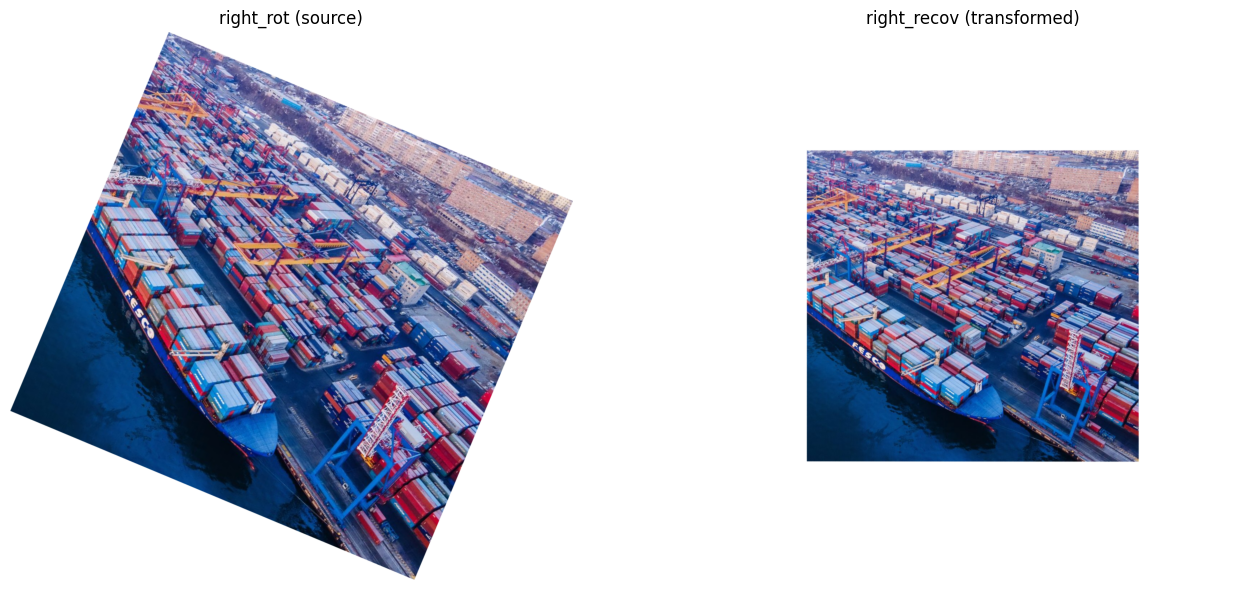

In [19]:
h_mid, w_mid = crop_mid.shape[:2]
h_right, w_right = right_rot.shape[:2]

corners_right = np.float32([
    [0, 0],
    [w_right, 0],
    [w_right, h_right],
    [0, h_right]
]).reshape(-1, 1, 2)

corners_transformed_R = cv2.perspectiveTransform(corners_right, H_R)

x_min_R = int(np.floor(corners_transformed_R[:, 0, 0].min()))
x_max_R = int(np.ceil(corners_transformed_R[:, 0, 0].max()))
y_min_R = int(np.floor(corners_transformed_R[:, 0, 1].min()))
y_max_R = int(np.ceil(corners_transformed_R[:, 0, 1].max()))

x_min_R = min(x_min_R, 0)
x_max_R = max(x_max_R, w_mid)
y_min_R = min(y_min_R, 0)
y_max_R = max(y_max_R, h_mid)

canvas_width_R = x_max_R - x_min_R
canvas_height_R = y_max_R - y_min_R

print(f"Canvas size: {canvas_width_R} x {canvas_height_R}")
print(f"Offsets: x_min={x_min_R}, y_min={y_min_R}")

translation_matrix_R = np.array([
    [1, 0, -x_min_R],
    [0, 1, -y_min_R],
    [0, 0, 1]
], dtype=np.float32)

H_R_shifted = translation_matrix_R @ H_R

right_recov = cv2.warpPerspective(
    right_rot,
    H_R_shifted,
    (canvas_width_R, canvas_height_R),
    flags=cv2.INTER_LINEAR,
    borderMode=cv2.BORDER_CONSTANT,
    borderValue=(255, 255, 255)
)

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.imshow(right_rot)
plt.axis("off")
plt.title("right_rot (source)")

plt.subplot(1, 2, 2)
plt.imshow(right_recov)
plt.axis("off")
plt.title("right_recov (transformed)")
plt.tight_layout()
plt.show()

Panorama successfully created!
Panorama shape: (1517, 2096, 3)


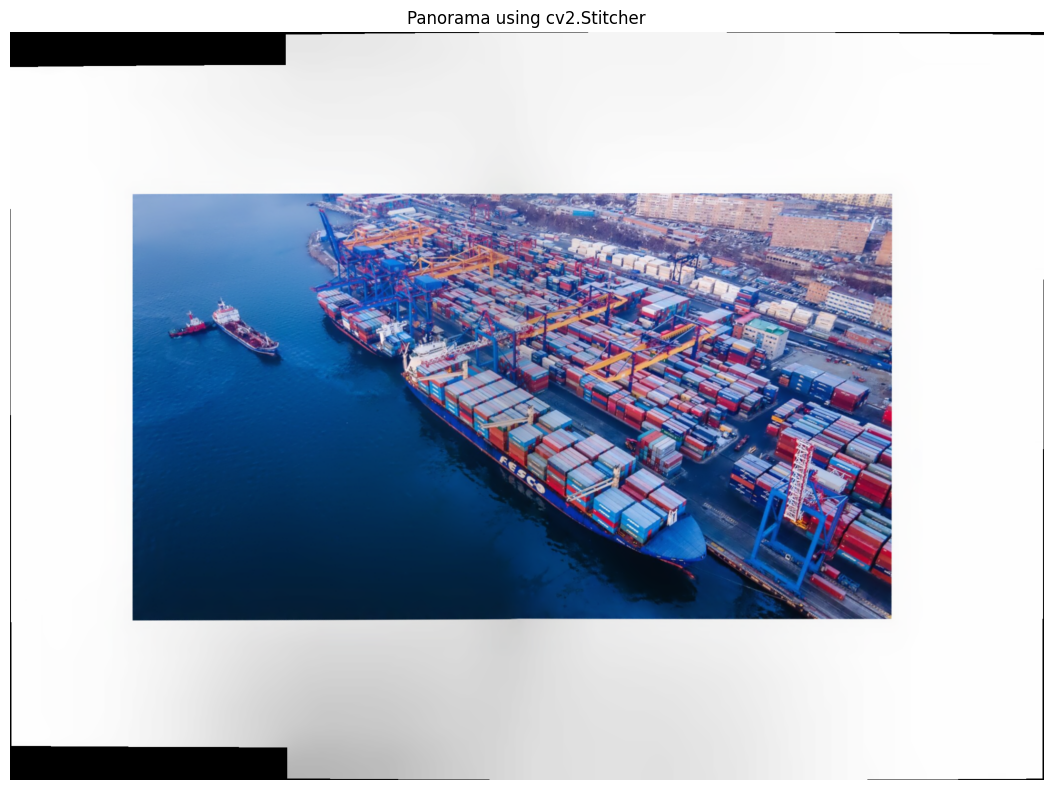

Saved as 'panorama_result.jpg'


In [20]:
images_to_stitch = [left_recov, crop_mid, right_recov]

stitcher = cv2.Stitcher_create(cv2.Stitcher_PANORAMA)

status, panorama = stitcher.stitch(images_to_stitch)

if status == cv2.Stitcher_OK:
    print("Panorama successfully created!")
    print(f"Panorama shape: {panorama.shape}")
    
    plt.figure(figsize=(20, 8))
    plt.imshow(panorama)
    plt.axis("off")
    plt.title("Panorama using cv2.Stitcher")
    plt.tight_layout()
    plt.show()
    
    cv2.imwrite("panorama_result.jpg", cv2.cvtColor(panorama, cv2.COLOR_RGB2BGR))
    print("Saved as 'panorama_result.jpg'")
